In [2]:
# Importing libraries and resources 
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
%matplotlib inline
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import LabelBinarizer
import statsmodels.api as sm
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import BaggingRegressor
from sklearn import ensemble


In [3]:
# Reading the data
data=pd.read_csv("housing.csv")

# Understanding the dataset

In [4]:
# Visualizing the data and the dataset dimensions
print(data.shape)
data.head()

(20640, 10)


longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

1. longitude: A measure of how far west a house is; a higher value is farther west
2. latitude: A measure of how far north a house is; a higher value is farther north
3. housingMedianAge: Median age of a house within a block; a lower number is a newer building
4. totalRooms: Total number of rooms within a block
5. totalBedrooms: Total number of bedrooms within a block
6. population: Total number of people residing within a block
7. households: Total number of households, a group of people residing within a home unit, for a block
8. medianIncome: Median income for households within a block of houses (measured in tens of thousands of US Dollars)
9. medianHouseValue: Median house value for households within a block (measured in US Dollars)
10. oceanProximity: Location of the house w.r.t ocean/sea

The variable ocean_proximty is Categorical. As we will run regression models, it's important to create a set o binaries (or dummies) variables to represent ocean_proximty. This transformation will make the results interpretable (mostly for linear regression). So, let's do it! 

In [5]:
# Ocean proximity to dummie

dummies=LabelBinarizer().fit_transform(data['ocean_proximity'])
data=data.join(pd.DataFrame(dummies,columns=["<1H OCEAN","INLAND","ISLAND","NEAR BAY","NEAR OCEAN"]))

data.tail(2)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
20638    -121.32     39.43                18.0       1860.0           409.0   
20639    -121.24     39.37                16.0       2785.0           616.0   

       population  households  median_income  median_house_value  \
20638       741.0       349.0         1.8672             84700.0   
20639      1387.0       530.0         2.3886             89400.0   

      ocean_proximity  <1H OCEAN  INLAND  ISLAND  NEAR BAY  NEAR OCEAN  
20638          INLAND          0       1       0         0           0  
20639          INLAND          0       1       0         0           0

In [6]:
# Missing data
data.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
<1H OCEAN               0
INLAND                  0
ISLAND                  0
NEAR BAY                0
NEAR OCEAN              0
dtype: int64

There are missing data for the variable total bedrooms!
To overcome this issue we will calculate the median for total bedrooms based upon categories of ocean proximity column.

In [7]:
# filling missing data

for i in data['ocean_proximity'].unique():
    median=data[data['ocean_proximity']==i]['total_bedrooms'].median()
    data.loc[data['ocean_proximity']==i,'total_bedrooms'] =  data[data['ocean_proximity']==i]['total_bedrooms'].fillna(median)
    
data.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
<1H OCEAN             0
INLAND                0
ISLAND                0
NEAR BAY              0
NEAR OCEAN            0
dtype: int64

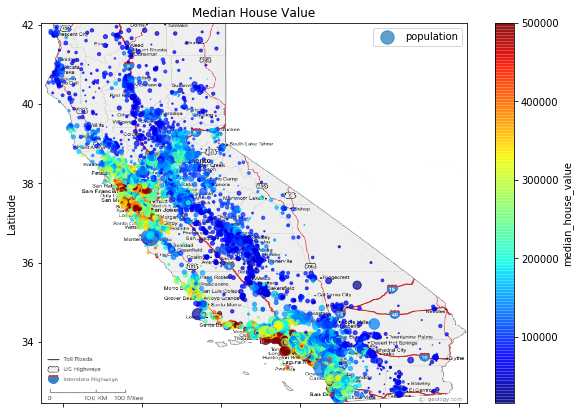

In [8]:
# Map chart: Visualizing the Median House Value

california_img=mpimg.imread('california.png')


data.plot(kind="scatter", x="longitude", y="latitude", title='Median House Value',
    s=data['population']/100, label="population",
    c="median_house_value", cmap=plt.get_cmap("jet"),
    colorbar=True, alpha=0.7, figsize=(10,7),
)


plt.ylabel("Latitude", fontsize=10)
plt.xlabel("Longitude", fontsize=10)

plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=1)

plt.legend()
plt.show()

In [9]:
# interactive map chart with plotly 

fig = go.Figure(data=go.Scattergeo(
        lon = data['longitude'],
        lat = data['latitude'],
        text = data['median_house_value'],
        mode = 'markers',
        marker_color = data['median_house_value'],
        ))

fig.update_layout(
        title = 'Median House Value in California',
        geo_scope='usa')
    
fig.show()

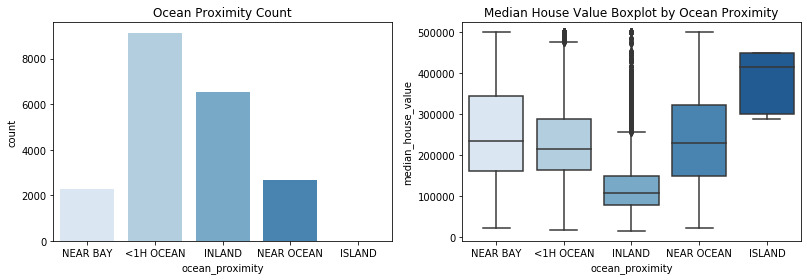

In [10]:
# ocean_proximity analysis 

fig=plt.figure(figsize=(17, 4))

plt.subplot(131)
g = sns.countplot(data=data,x="ocean_proximity",palette="Blues",orient="v",dodge=True).set_title('Ocean Proximity Count')

plt.subplot(132)
sns.boxplot( x=data["ocean_proximity"], y=data["median_house_value"], palette="Blues").set_title('Median House Value Boxplot by Ocean Proximity')

plt.tight_layout()
plt.show()


The map chart indicates that the price of the houses is more expensive near to the ocean. The Boxplot is inline with the map, once we can easily note that houses inland are cheaper.
The island houses are much more expensive and outnumbered.


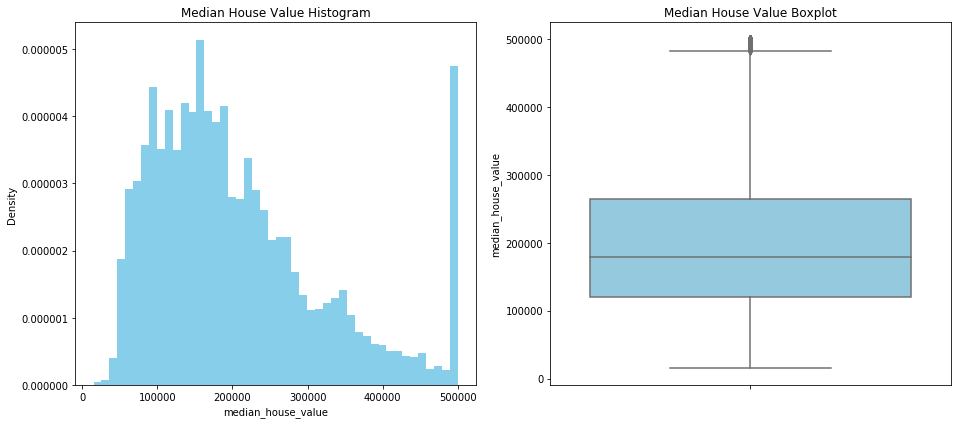

In [11]:
# Histograma de median_house_value
from scipy.stats import iqr
fig = plt.figure(figsize=(20, 6))

bin_width = 2 * iqr(data["median_house_value"]) / len(data)**(1/3)
num_bins = (np.max(data["median_house_value"]) - np.min(data["median_house_value"])) / bin_width

plt.subplot(131)
(sns.distplot(data["median_house_value"], bins = "fd", norm_hist = True, kde = False, color = "skyblue", hist_kws = dict(alpha = 1))
    .set(xlabel = "median_house_value", ylabel = "Density", title = "Median House Value Histogram"));

plt.subplot(132)
sns.boxplot(y=data["median_house_value"], color="skyblue").set_title('Median House Value Boxplot')

plt.tight_layout()
plt.show()


The charts above show the median_house_value distribution. 
An interesting fact is that there is a high frequency on the value of 50000. Most likely, this value is a cap, hence all the median_house_value above 50000 was reduced to this value. 

In [12]:
# Descriptive analysis 
data[['longitude','latitude','housing_median_age','total_rooms','total_bedrooms','population','households','median_income','median_house_value']].describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20640.000000  20640.000000  20640.000000   20640.000000   
mean       536.852229   1425.476744    499.539680       3.870671   
std        419.390765   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        297.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        643.250000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

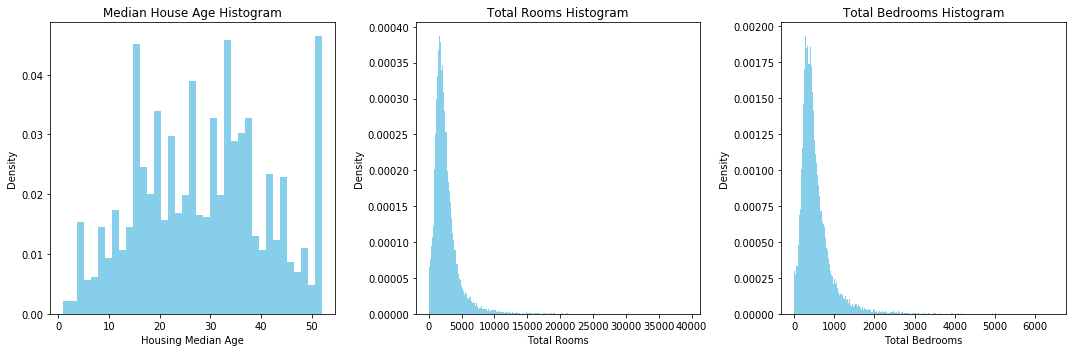

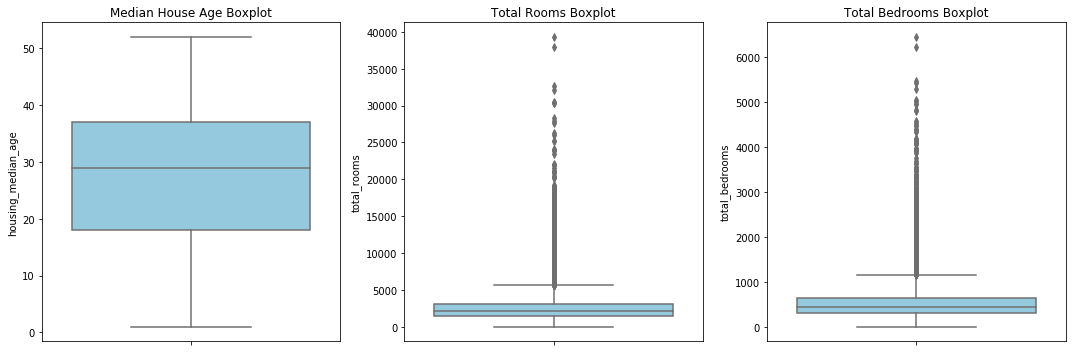

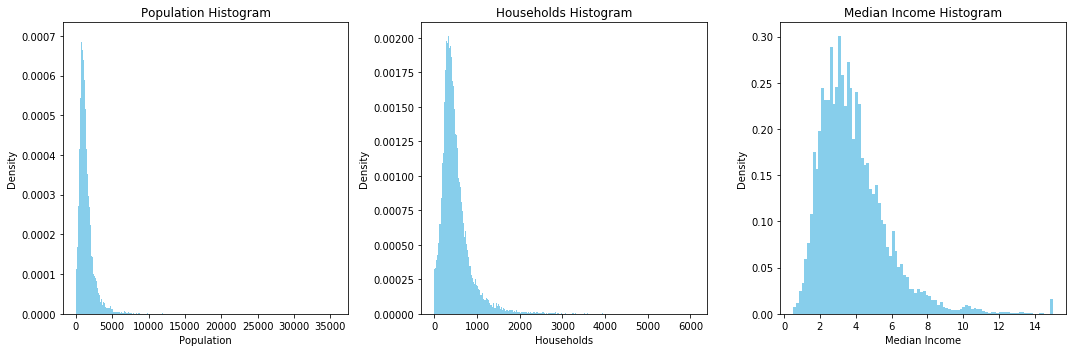

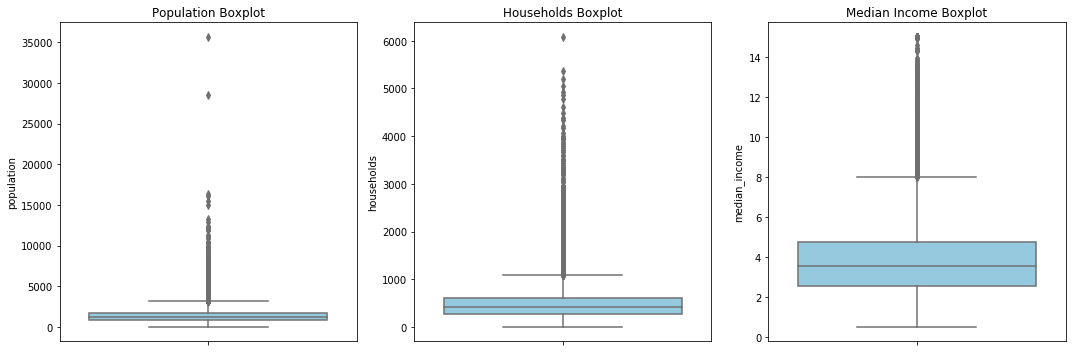

In [13]:
# Histogram

fig = plt.figure(figsize=(15, 5))

plt.subplot(131)

(sns.distplot(data["housing_median_age"], bins = "fd", norm_hist = True, kde = False, color = "skyblue", hist_kws = dict(alpha = 1))
    .set(xlabel = "Housing Median Age", ylabel = "Density", title = "Median House Age Histogram"));

plt.subplot(132)

(sns.distplot(data["total_rooms"], bins = "fd", norm_hist = True, kde = False, color = "skyblue", hist_kws = dict(alpha = 1))
    .set(xlabel = "Total Rooms", ylabel = "Density", title = "Total Rooms Histogram"));

plt.subplot(133)

(sns.distplot(data["total_bedrooms"], bins = "fd", norm_hist = True, kde = False, color = "skyblue", hist_kws = dict(alpha = 1))
    .set(xlabel = "Total Bedrooms", ylabel = "Density", title = "Total Bedrooms Histogram"));

plt.tight_layout()
plt.show()

# Boxplot

fig = plt.figure(figsize=(15, 5))

plt.subplot(131)
sns.boxplot(y=data["housing_median_age"], color="skyblue").set_title('Median House Age Boxplot')

plt.subplot(132)
sns.boxplot(y=data["total_rooms"], color="skyblue").set_title('Total Rooms Boxplot')

plt.subplot(133)
sns.boxplot(y=data["total_bedrooms"], color="skyblue").set_title('Total Bedrooms Boxplot')

plt.tight_layout()
plt.show()


# Histogram

fig = plt.figure(figsize=(15, 5))

plt.subplot(131)

(sns.distplot(data["population"], bins = "fd", norm_hist = True, kde = False, color = "skyblue", hist_kws = dict(alpha = 1))
    .set(xlabel = "Population", ylabel = "Density", title = "Population Histogram"));

plt.subplot(132)

(sns.distplot(data["households"], bins = "fd", norm_hist = True, kde = False, color = "skyblue", hist_kws = dict(alpha = 1))
    .set(xlabel = "Households", ylabel = "Density", title = "Households Histogram"));

plt.subplot(133)

(sns.distplot(data["median_income"], bins = "fd", norm_hist = True, kde = False, color = "skyblue", hist_kws = dict(alpha = 1))
    .set(xlabel = "Median Income", ylabel = "Density", title = "Median Income Histogram"));

plt.tight_layout()
plt.show()


# Boxplot 

fig = plt.figure(figsize=(15, 5))

plt.subplot(131)
sns.boxplot(y=data["population"], color="skyblue").set_title('Population Boxplot')

plt.subplot(132)
sns.boxplot(y=data["households"], color="skyblue").set_title('Households Boxplot')

plt.subplot(133)
sns.boxplot(y=data["median_income"], color="skyblue").set_title('Median Income Boxplot')

plt.tight_layout()
plt.show()


The charts and descriptive analysis above help us to visualize the distribution of all numerical variables. 

In [14]:
(data[['longitude','latitude','housing_median_age','total_rooms','total_bedrooms','population','households','median_income','median_house_value']]
 .corr().style.background_gradient( axis=None))

The correlation matrix is a good way to visualize how the variables behave along with each other. It's also very useful for linear regression problems, once it helps us to select regressors high correlated with the response variables. As well as it will help us to avoid multicollinearity between the regressors.

# Training and Test Set

Now, we will try to predict the median_house_value. So we will split the data into training and test set.

In [15]:
# Removing categorical column  
data=data.drop(['ocean_proximity'],axis=1)
print(data.shape)
data.head()

(20640, 14)


longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value  <1H OCEAN  \
0       322.0       126.0         8.3252            452600.0          0   
1      2401.0      1138.0         8.3014            358500.0          0   
2       496.0       177.0         7.2574            352100.0          0   
3       558.0       219.0         5.6431            341300.0          0   
4       565.0       259.0         3.8462            342200.0          0   

   INLAND  ISLAND  NEAR BAY  NEAR OCEAN  
0       0       0         1           0  
1       0       0         1           0  
2       0       0         1           0  
3       0       0         1           0  
4       0       0         1           0

In [16]:
#  splitting the data into attributes and labels:
#  response variable: meadian_house_value

X = data.drop(['median_house_value'],axis=1).values
y = data.iloc[:, 8].values

On the step above, we could select just some variable aiming to improve the model's performance, by removing some high correlated regressors or by testing the performance of each model. But we are not going to do it, we will simply run all the models (Linear Regression, Decision Trees, Random Forest and Boosting) with all the variables. 

The idea here is to explain and show how each model works, without trying to improve the prediction performance. (At least for now). 

In [17]:
# splitting the data into training and testing sets:
# 20% for testing 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [18]:
# feature scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Linear Regression

Linear regression models are useful for prediction and to explain variation in the response variable. In this case, we will focus on prediction. So we will fit a predictive model to an observed data set of values of the response and explanatory variables. 

<p style="font-size:120%;">\begin{equation*}Y= \beta _{0} + \beta _{1}X_{1}+\beta _{2}X_{2}+\varepsilon\end{equation*}</p>

To run the linear model we will use a class from Scikit-learn called <b> Linear Regression() </b> this class has a function called <b> fit() </b>, which will train our data.

In [19]:
# Linear Regression 

from sklearn.linear_model import LinearRegression

regressor_linear = LinearRegression()

regressor_linear.fit(X_train,y_train)

y_pred_lr = regressor_linear.predict(X_test) 


We can see above, that the variable regressor_linear is a Linear Regression model trained from the variables X_train and y_train. To train the model means that we are looking for the line that better fits the training data, to do so we will use the <b>predict()</b> function. 

![title](linear.png)


In [20]:
print('Mean Absolute Error:', np.round(metrics.mean_absolute_error(y_test, y_pred_lr),2))

print('Mean Squared Error:', np.round(metrics.mean_squared_error(y_test, y_pred_lr),2))

print('Root Mean Squared Error:', np.round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_lr)),2))

Mean Absolute Error: 49182.13
Mean Squared Error: 4724425262.69
Root Mean Squared Error: 68734.45


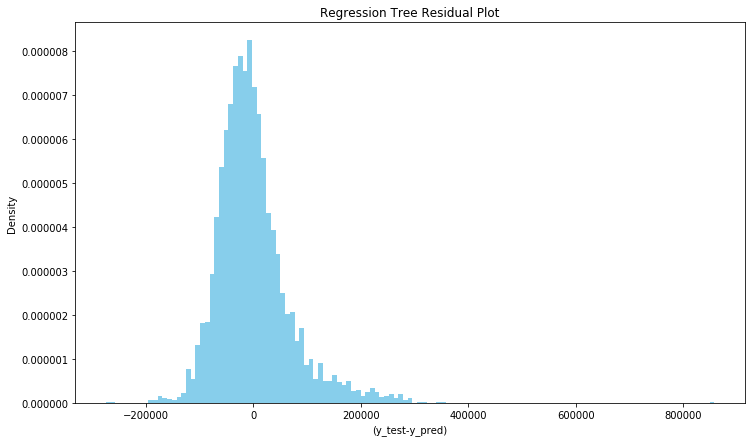

In [21]:
# residual plot
plt.figure(figsize=(12,7))
(sns.distplot((y_test-y_pred_lr), bins = "fd", norm_hist = True, kde = False, color = "skyblue", hist_kws = dict(alpha = 1))
    .set(xlabel = "(y_test-y_pred)", ylabel = "Density", title = "Regression Tree Residual Plot"));

# Regression Trees

Decision Trees methods involve stratifying or segmenting the predictor space into a number of simple regions. Decision Trees are <b>simple and useful for interpretation</b>, however they are typically <b>not competitive in terms of prediction accuracy</b>.

Decision trees can be applied to both <b>regression and classification problems</b>. At this task, we are going to use <b>Regression Trees</b>

<p style="color:green;">Advantages of Decision Trees: </p>

1. Trees are very easy to explain to people. In fact, they are even easier to explain than linear regression!
2. Some people believe that decision trees more closely mirror human decision-making than do the regression and classification approaches seen in previous chapters.
3. Trees can be displayed graphically, and are easily interpreted even by a non-expert (especially if they are small).
4. Trees can easily handle qualitative predictors without the need to create dummy variables, 

<p style="color:red;">Disadvantages of Decision Trees: </p>

1. Unfortunately, trees generally do not have the same level of predictive accuracy as some of the other regression and classification approaches seen in this book.
2. Additionally, trees can be very non-robust. In other words, a small change in the data can cause a large change in the final estimated tree (high variance). 

However, by aggregating many decision trees the predictive performance of trees can be substantially improved. We will evaluate these models in the next cells. 


In [22]:
# training the model
regressor_tree = DecisionTreeRegressor(random_state = 123)  
regressor_tree.fit(X_train, y_train)
y_pred_tree = regressor_tree.predict(X_test) 

In [23]:
# evaluating the algorithm 

print('Mean Absolute Error:', np.round(metrics.mean_absolute_error(y_test, y_pred_tree),2))

print('Mean Squared Error:', np.round(metrics.mean_squared_error(y_test, y_pred_tree),2))

print('Root Mean Squared Error:', np.round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_tree)),2))

Mean Absolute Error: 42428.05
Mean Squared Error: 4416229696.6
Root Mean Squared Error: 66454.72


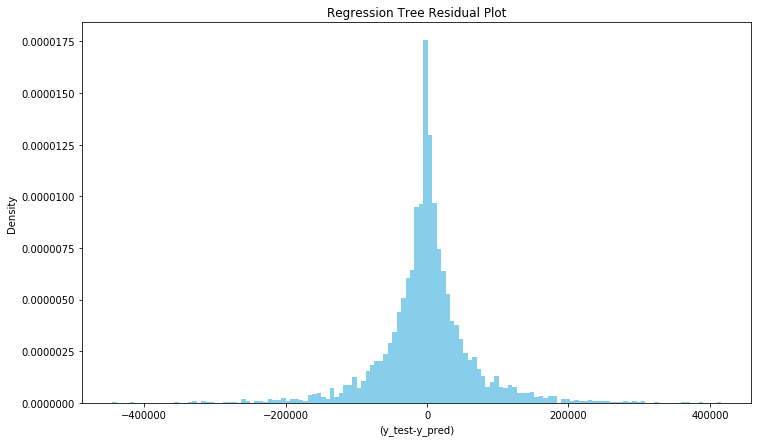

In [24]:
# residual plot
plt.figure(figsize=(12,7))
(sns.distplot((y_test-y_pred_tree), bins = "fd", norm_hist = True, kde = False, color = "skyblue", hist_kws = dict(alpha = 1))
    .set(xlabel = "(y_test-y_pred)", ylabel = "Density", title = "Regression Tree Residual Plot"));

# Bagging 

As discussed above, <b>Decision Trees suffer from high variance</b>, bagging is a method that aims improve the perfome of the Decision Trees. An intuitive alternative to reduce the variance and hence <b>increase the prediction accuracy is to take many training sets from the population</b>, build a separate prediction model using each training set and avarage the resulting predictions. Where B is the number of separate training sets.
<p style="font-size:120%;">\begin{equation*}{\hat{f}}_{avg}(x)=\frac{1}{B}\sum_{b=1}^{B}\hat{f}^{b}(x)\end{equation*}</p>

Of course, this is not practical because we <b>generally do not have access to multiple training sets</b>.
Instead, we can <b>bootstrap, by taking repeated samples from the (single) training data set</b>. In this approach we generate B different bootstrapped training data sets.

<p style="font-size:120%;">\begin{equation*}{\hat{f}}_{bag}(x)=\frac{1}{B}\sum_{b=1}^{B}\hat{f}^{*b}(x)\end{equation*}</p>

Before continue into Bagging, lets go deeper into the concept of <b>Boostrap.</b>

The figure bellow is a graphical illustration of the bootstrap approach on a small sample containing n = 3 observations. Each bootstrap dataset contains n observations, sampled with replacement from the original dataset. Each bootstrap dataset is used to obtain an estimate of α.

![title](bootstrap.png)

Altough Bootstrapping can usefull for many statistical learning methods, here we are foccusing on <b>applying bagging for Decision Trees in regression problems.</b>. So, how does it works? 
<i>
1. Select a orginal dataset (training set).

2. Randomly select samples from the origial dataset allowing replacement to create a new dataset with the same size as the original dataset. Each re-sample will be called a Bootstrapped dataset and we will have a total of B Bootstrapped datasets. 

3. Generate a decision tree (regression tree) for each bootstrapped dataset considering all variables (we will discuss the details of it on Random Forest) to obtain an estimate of α.

4. As its regression problem, we should average the predictions of all B trees to get our bagging prediction result. 
</i>
During the <b>bagging process</b>, all the <b>trees are grown deep</b>, and are not pruned. Hence <b>each individual tree has high variance, but low bias. Averaging these B trees reduces the variance. </b>

The number of trees B is not a critical parameter with bagging; using a <b>very large value of B will not lead to overfitting.</b>

Learn more: https://www.youtube.com/watch?v=J4Wdy0Wc_xQ



In [25]:
# training the model

regressor_bagging = BaggingRegressor(n_estimators=200,random_state=123)
regressor_bagging=regressor_bagging.fit(X_train,y_train)
y_pred_bagging = regressor_bagging.predict(X_test)


In [26]:
# evaluating the algorithm 

print('Mean Absolute Error:', np.round(metrics.mean_absolute_error(y_test, y_pred_bagging),2))

print('Mean Squared Error:', np.round(metrics.mean_squared_error(y_test, y_pred_bagging),2))

print('Root Mean Squared Error:', np.round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_bagging)),2))



Mean Absolute Error: 30867.25
Mean Squared Error: 2243131766.56
Root Mean Squared Error: 47361.71


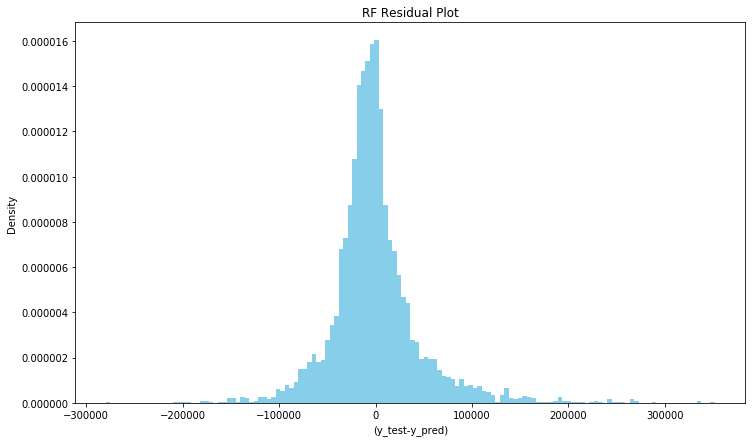

In [27]:
# residual plot
plt.figure(figsize=(12,7))
(sns.distplot((y_test-y_pred_bagging), bins = "fd", norm_hist = True, kde = False, color = "skyblue", hist_kws = dict(alpha = 1))
    .set(xlabel = "(y_test-y_pred)", ylabel = "Density", title = "RF Residual Plot"));


# Random Forest

Random Forest is an evolution of bagging. The Random Forest model provide an <b>improvement over bagged trees</b> by way of a small tweak that <b>decorrelates the trees</b>.

As in bagging, we build a number of decision trees on bootstrapped training samples. But when building these decision trees, each time a split in a tree is considered, a <b>random sample of m predictors is chosen as split candidates from the full set of p predictors</b>. The idea behind this process is to decorrelate the trees, for example: Suppose that there is one very strong predictor in the data set, along with a number of other moderately strong predictors. Then in the collection of bagged trees, most or all of the trees will use this strong predictor in the top split. Consequently, all of the bagged trees will look quite similar to each other. Hence the predictions from the bagged trees will be highly correlated.

In Random Forest <i>p</i> is the full set of predictors and <i> m </i> is the predictors taken at each split. So, <b>the main difference between bagging and random forests is the choice of predictor subset size m</b>. For instance, if a random forest is built using m = p, then this amounts simply to bagging.

    

In [28]:
# training the model
regressor_rf = RandomForestRegressor(n_estimators=200, random_state=123)
regressor_rf.fit(X_train, y_train)
y_pred_rf = regressor_rf.predict(X_test)

In [29]:
# evaluating the algorithm 

print('Mean Absolute Error:', np.round(metrics.mean_absolute_error(y_test, y_pred_rf),2))

print('Mean Squared Error:', np.round(metrics.mean_squared_error(y_test, y_pred_rf),2))

print('Root Mean Squared Error:', np.round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf)),2))


Mean Absolute Error: 30841.53
Mean Squared Error: 2241804570.47
Root Mean Squared Error: 47347.7


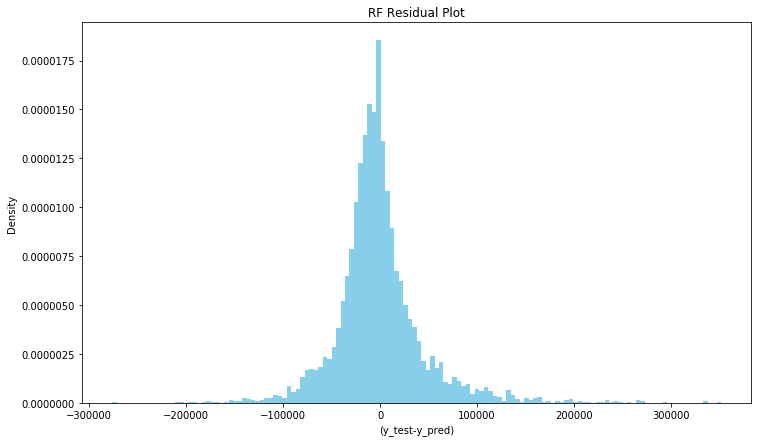

In [30]:
# residual plot
plt.figure(figsize=(12,7))
(sns.distplot((y_test-y_pred_rf), bins = "fd", norm_hist = True, kde = False, color = "skyblue", hist_kws = dict(alpha = 1))
    .set(xlabel = "(y_test-y_pred)", ylabel = "Density", title = "RF Residual Plot"));


# Boosting

As showed earlier, bagging involves creating multiple copies of the original training data set using the bootstrap, fitting a separate decision tree to each copy, and then combining all of the trees in order to create a single predictive model. Like bagging, <b>boosting involves combining a large number of decision trees, but boosting does not involve bootstrap sampling</b>. So, how does improve the perfomance? The key idea behind boosting is to <b>fit the new predictor to the residual errors made by the previous regression tree</b>. That is, we fit a tree using the current residuals, rather than the outcome Y , as the response. We then add this new decision tree into the fitted function in order to update the residuals. This process allows to slowly improve the predictions in areas where it does not perform well.

Boosting has three tuning parameters: 
<i>
1. The number of trees B. We can use cross-validation to select B. 

2. The shrinkage parameter λ, a small positive number (typical values are 0.01 or 0.001). This controls the rate at which boosting learns. 

3. The number $d$ of splits in each tree.

</i>

Here we can see a general Boosting algorithm for regression problems. 

1. Set $\hat{f}(x)=0$ and $r_{i}=y_{i}$ for $i$ in the training set.


2. For b in 1,2,3...,B, repeat: 

   (a) Fit a tree $\hat{f}^{b}$ with $d$ splits ($d$+1 terminal nodes) to the training data (X,$r$).
   
   (b) Update  $\hat{f}$ by adding in a shrunken version of the new tree: $ \hat{f}(x) \leftarrow \hat{f}(x) +\lambda \hat{f}^{b}(x)  $
   
   (c) Update the residuals: $r_{i} \leftarrow r_{i} +\lambda \hat{f}^{b}(x_{i}) $
   
   

3. Output the boosted model: $\hat{f}(x) = \sum_{b=1}^{B}\lambda \hat{f}^{b}(x_{i})$


Unlike bagging and random forests, boosting can overfit if B is too large. Therefore it is important to make sure we are using validation splits/cross-validation to make sure we are not overfitting our Boosting models. 

The main idea behind Boosting is <b>to combine weak learner after weak learner</b>, our final model is able to account for a lot of the error from the original model <b>and reduces this error over time.</b>

In this case, we are going to use gradient boosting.


In [31]:
# setting the parameters
params = {
    'n_estimators': 200,
    'learning_rate': 0.015,
    'max_depth': 10,
    'min_samples_split': 2,
    'loss': 'ls',
}

# training the model
regressor_boosting = ensemble.GradientBoostingRegressor(**params)
regressor_boosting.fit(X_train, y_train)
y_pred_boosting=regressor_boosting.predict(X_test)

In [32]:
# evaluating the algorithm 

print('Mean Absolute Error:', np.round(metrics.mean_absolute_error(y_test, y_pred_boosting),2))

print('Mean Squared Error:', np.round(metrics.mean_squared_error(y_test, y_pred_boosting),2))

print('Root Mean Squared Error:', np.round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_boosting)),2))



Mean Absolute Error: 32626.06
Mean Squared Error: 2382585794.79
Root Mean Squared Error: 48811.74


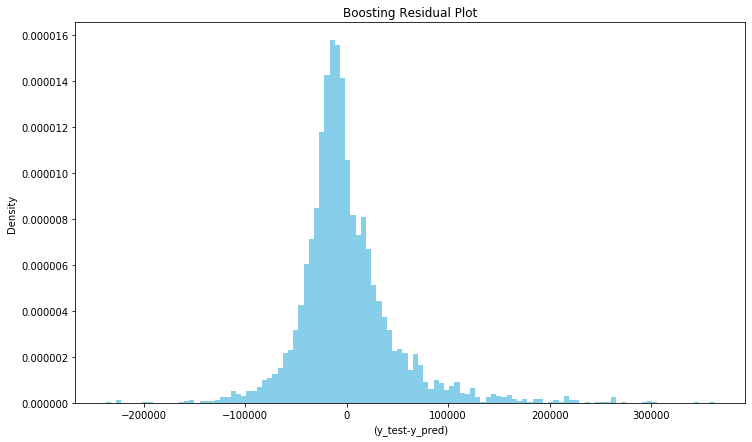

In [33]:
# residual plot
plt.figure(figsize=(12,7))
(sns.distplot((y_test-y_pred_boosting), bins = "fd", norm_hist = True, kde = False, color = "skyblue", hist_kws = dict(alpha = 1))
    .set(xlabel = "(y_test-y_pred)", ylabel = "Density", title = "Boosting Residual Plot"));

